In [1]:
import dmrs_functions
from collections import namedtuple
import goal_updates
import ff
import prob_model
import world
import copy

In [2]:
correction_type1 = 'No, put red blocks on blue blocks'
correction_type2 = 'No, now you cannot put b3 in the tower because you must put red blocks on blue blocks'

In [3]:
Message = namedtuple('Message', ['rel', 'o1', 'o2', 'T', 'o3'])

def get_adjectives(obj):
    return [dmrs_functions.get_pred(node['predicate']) for node in obj if dmrs_functions.get_pos(node['predicate']) == 'a']

def read_sentence(sentence):
    sentence = sentence.lower().strip('no,')
    o3 = None
    T = 'tower'
    if 'tower because you must' in sentence:
        T = 'table'
        o3 = sentence.split('put')[1].split('in')[0].strip()
        sentence = sentence.split('because you must')[1].strip()
    rel, o1, o2= dmrs_functions.sent_to_tripple(sentence)
    o1 = get_adjectives(o1)
    o2 = get_adjectives(o2)
    rel = dmrs_functions.get_pred(rel['predicate'])
    return Message(rel, o1, o2, T, o3)

    

In [4]:
read_sentence(correction_type1)

Message(rel='on', o1=['red'], o2=['blue'], T='tower', o3=None)

In [5]:
read_sentence(correction_type2)

Message(rel='on', o1=['red'], o2=['blue'], T='table', o3='b3')

In [6]:
rules = goal_updates.create_goal_options(['red'], ['blue'])
{tuple(rules): 1}

{(<pythonpddl2.pddl.Formula at 0x7f5303d0df60>,
  <pythonpddl2.pddl.Formula at 0x7f53340d0668>): 1}

In [7]:
r1 = rules[0]
r1.asPDDL()

'(forall (?x ?y) (or (not (red ?x)) (blue ?y)))'

In [8]:
rules = goal_updates.create_goal_options(['red'], ['blue'])
rules

In [9]:
class Agent(object):


    def plan(self):
        raise NotImplementedError()

    def act(self, action):
        raise NotImplementedError()


In [22]:


class CorrectingAgent(Agent):

    def __init__(self, world, colour_models = {}, rule_beliefs = {}, domain_file='blocks-domain.pddl'):
        self.world = world
        self.domain = world.domain
        self.domain_file = domain_file
        observation = world.sense()
        self.problem = copy.deepcopy(world.problem)
        self.goal = self.problem.goal
        self.problem.initialstate = observation.state
        self.colour_models = colour_models
        self.rule_beliefs = rule_beliefs
        self.threshold = 0.7

    def plan(self):
        with open('tmp/problem.pddl', 'w') as f:
            f.write(self.problem.asPDDL())

        plan = ff.run(self.domain_file, 'tmp/problem.pddl')
        return plan

    def get_correction(self, user_input, action, args):
        message = read_sentence(user_input)
        rule_model, rules = self.build_model(message)
        
        data = self.get_data(message, args)
        
        rule_beliefs = rule_model.update_belief_r(data)
        print(rule_beliefs)
        
        self.rule_beliefs[rule_model.rules] = rule_beliefs
        if rule_beliefs[0] > self.threshold:
            self.goal = goal_updates.update_goal(self.goal, rules[0])
            self.problem.goal = self.goal
            
        elif rule_beliefs[1] > self.threshold:
            self.goal = goal_updates.update_goal(self.goal, rules[1])
            self.problem.goal = self.goal
        
        else:
            answer = input('Is the top object {}?'.format(message.o1[0]))
            bin_answer = int(answer.lower() == 'yes')
            rule_beliefs = rule_model.update_belief_r(data, visible={message.o1[0]:bin_answer})
            if rule_beliefs[0] > self.threshold:
                self.goal = goal_updates.update_goal(self.goal, rules[0])
                self.problem.goal = self.goal

            elif rule_beliefs[1] > self.threshold:
                self.goal = goal_updates.update_goal(self.goal, rules[1])
                self.problem.goal = self.goal
       
        rule_model.update_c(data)
        
        
        
        
    def get_data(self, message, args):
        observation = self.sense()
        
        c1 = message.o1[0]
        c2 = message.o2[0]
        c3 = '{}/{}'.format(c1, c2)
        o1 = args[0]
        o2 = args[1]
        o3 = message.o3
        colour_data = observation.colours
        try:
            data_dict = {c1:colour_data[o1], c2:colour_data[o2], c3:colour_data[o3]}
        except KeyError:
            data_dict = {c1:colour_data[o1], c2:colour_data[o2]}
        return data_dict
        
        

    def build_model(self, message):
        rules = goal_updates.create_goal_options(message.o1, message.o2)
        rule_names = tuple(map(lambda x: x.asPDDL(), rules))
        
        if rule_names in self.rule_beliefs.keys():
            rule_probs = self.rule_beliefs[rule_names] # this will probably have to change
        
        else:
            rule_probs = (0.5, 0.5)
        
        c1 = message.o1[0]
        c2 = message.o2[0]
        try:
            colour_model1 = self.colour_models[c1]
        except KeyError:
            colour_model1 = prob_model.ColourModel(c1)
            self.colour_models[c1] = colour_model1
        try:
            colour_model2 = self.colour_models[c2]
        except KeyError:
            colour_model2 = prob_model.ColourModel(c2)
            self.colour_models[c2] = colour_model2
        
        if message.T == 'tower':
            rule_model = prob_model.CorrectionModel(rule_names, colour_model1, colour_model2, rule_belief=rule_probs)
            
        else:
            rule_model = prob_model.TableCorrectionModel(rule_names, colour_model1, colour_model2, rule_belief=rule_probs)
        return rule_model, rules
    
    def sense(self):
        return self.world.sense()

Parsing domain blocks-domain.pddl
Parsing problem blocks_problem_default.pddl


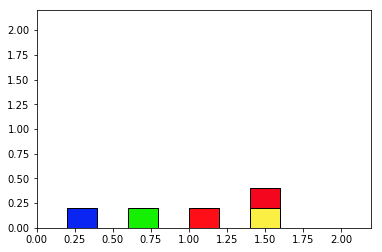

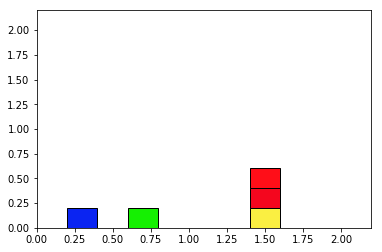

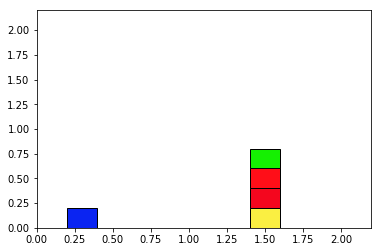

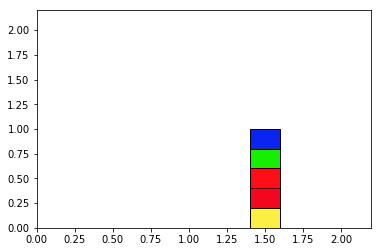

In [26]:
w = world.PDDLWorld('blocks-domain.pddl', 'blocks_problem_default.pddl')
agent = CorrectingAgent(w)
plan = agent.plan()
for a, args in plan:
    w.update(a, args)
    w.draw()

In [12]:
model.rule_belief

NameError: name 'model' is not defined

In [25]:
agent.get_correction(correction_type2, args, args)

(0.5000000000000001, 0.49999999999999994)
Is the top object red?no


In [15]:
agent.goal.asPDDL()

'(and (forall (?x) (in-tower ?x)) (forall (?x ?y) (or (not (red ?x)) (blue ?y))))'

In [ ]:
model, rules = agent.build_model(message)

In [ ]:
data = agent.get_data(message, args)

In [ ]:
blue = agent.colour_models['blue']

In [ ]:
import numpy as np

In [ ]:
blue.update_mu(data['blue'], np.array(0.5))

In [ ]:
data

In [ ]:
model.update_c(data)

In [ ]:
args

In [ ]:
message = read_sentence(correction_type1)

In [ ]:
agent.get_data(message, args)

In [ ]:
g = agent.problem.goal

In [ ]:
g.subformulas[0].asPDDL()

In [ ]:
from pythonpddl2.pddl import Predicate, TypedArg, TypedArgList, Formula


In [ ]:
g = update_goal(g, r1)

In [ ]:
g.asPDDL()